In [ ]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [ ]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_z_obs = _z_obs[lcc]
_N = _A_obs.shape[0]

In [ ]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [ ]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [ ]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [ ]:
rw_len = 16
batch_size = 128

In [ ]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [ ]:
walker.walk().__next__()

#### Create our NetGAN model

In [ ]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=1, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128, noise_dim=2,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

#### Define the stopping criterion

In [ ]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [ ]:
eval_every = 2000
plot_every = 2000

In [ ]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=200000)

In [ ]:
log_dict.keys()

In [ ]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [ ]:
noise_tf = tf.placeholder(tf.float32, shape=[10000, netgan.noise_dim])

In [ ]:
sample_many = netgan.generate_discrete(10000, reuse=True, z=noise_tf)

In [ ]:
from scipy.special import ndtri

In [ ]:
all_walks = []
all_noise = []
before = time.time()
iterations =   6000 #29144
for it in range(iterations):
    noise = np.random.uniform(low=0, high=1, size=[10000, netgan.noise_dim])
    gaussian_noise = ndtri(noise)
    walks = sample_many.eval(feed_dict={noise_tf: gaussian_noise, netgan.tau:0.5})
    all_walks.extend(list(walks))
    all_noise.extend(list(noise))
    if (it+1) % 100 == 0:
        elapsed = time.time() - before
        print("{}/{} took {}, eta {}".format(it+1, iterations, elapsed, iterations/(it+1)*elapsed - elapsed))

np.savez_compressed("walks.npz", 
                    walks = np.array(all_walks).astype("uint16"),
                    noise = np.array(all_noise))

In [ ]:
all_walks = np.array(all_walks)
all_noise = np.array(all_noise)

In [ ]:
all_walks.shape

In [ ]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

## Latent space heatmaps

In [ ]:
n_bins = 20
bins = np.arange(0, 1, 1/n_bins)

In [ ]:
noise_bins = np.floor(all_noise /  (1/n_bins)).astype('int')

### Here we generate a graph from the random walks in each bin and measure their properties

In [ ]:
graphs_bins = [[None for i in range(n_bins)] for j in range(n_bins)]
matrices = [[None for i in range(n_bins)] for j in range(n_bins)]
statistics = [[None for i in range(n_bins)] for j in range(n_bins)]
begin = time.time()
it = 0

for x1 in range(n_bins):
    for x2 in range(n_bins):
        it += 1
        graphs_bins[x1][x2] = utils.score_matrix_from_random_walks(all_walks[np.where((noise_bins[:,0] == x1) &
                                                                       (noise_bins[:,1] == x2))], netgan.N)
        graph_select = utils.graph_from_scores(graphs_bins[x1][x2], A_select.sum())
        matrices[x1][x2] = sp.coo_matrix(graph_select)
        statistics[x1][x2] = utils.compute_graph_statistics(graph_select)
        elapsed = time.time() - begin
    print("{}/{} took {:.2f}, eta {:.2f}".format(it, n_bins**2, elapsed, (n_bins**2)/(it)*elapsed - elapsed))
    

In [ ]:
ks = list(statistics[0][0].keys())
statistics_dict = {k: np.array([y[k] for x in statistics for y in x]).reshape((n_bins, n_bins)) for k in ks}

In [ ]:
first_nodes = all_walks[:,0]
degrees = A_select.sum(0).A1
unique, indices, counts = np.unique(first_nodes, return_counts=True, return_inverse=True)

In [ ]:
first_node_degrees = degrees[first_nodes]

In [ ]:
from scipy.stats import entropy

### Here we compute some statistics of the random walks themselves

In [ ]:
entropies = np.zeros([n_bins, n_bins])
one_comm = np.zeros([n_bins, n_bins])
unique_nodes = np.zeros([n_bins, n_bins])
first_node_comm = np.zeros([n_bins, n_bins])
for x in range(n_bins):
    print(x)
    for y in range(n_bins):
        sel = all_walks[(noise_bins[:,0] == x) & (noise_bins[:,1] == y),:]
        ons = np.ones_like(sel)
        first_node_communities = ons * np.expand_dims(_z_obs[sel[:,0]],1)
        first_node_comm[x,y] = np.mean(_z_obs[sel] == first_node_communities)
        
        unique_firstnodes = np.unique(sel[:,0], return_counts=True)[1]
        entr = entropy(unique_firstnodes) / np.log(len(unique_firstnodes))
        entropies[x, y] = entr
        
        communities = _z_obs[sel]
        share_one_community = (np.std(communities, axis=1) == 0).mean()
        one_comm[x,y] = share_one_community
        unique_nodes[x,y] = np.mean(list(map(len,(map(set,(map(tuple, sel)))))))
        
statistics_dict['unique_nodes'] = np.array(unique_nodes)
statistics_dict['one_community'] = np.array(one_comm)
statistics_dict['first_node_entropy'] = np.array(entropies)
statistics_dict['first_node_community'] = np.array(first_node_comm)

In [ ]:
statistics_dict['claw_count'] = np.log(statistics_dict['claw_count'])

In [ ]:
statistics_dict['avg_starting_degree'] = np.array([np.mean(first_node_degrees[(noise_bins[:,0] == x) & (noise_bins[:,1] == y) ])
       for x in range(n_bins) for y in range(n_bins)]).reshape((n_bins, n_bins))

Store the results to disk so that we don't have to run all of this again

In [ ]:
np.savez_compressed('intermediate/results_{}x{}.npz'.format(n_bins, n_bins), 
                    graphs = matrices,
                    statistics = statistics_dict)

## Load statistics from file (start here if you just want to run the visualization)

### Uncomment the following to load from disk

In [ ]:
#results = np.load('intermediate/results_{}x{}.npz'.format(n_bins, n_bins))
#matrices = results['graphs']
#statistics_dict = results['statistics'].item()

In [ ]:
plt.rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
def heatmap(scores, ax, title=None, cbar=True):  
    pl = ax.imshow(np.array(scores), cmap='inferno', interpolation='nearest', extent=[0,1,0,1])

    if title is not None:
        plt.title(title, fontsize=15)

    ax.set_xticks([0,1])
    ax.get_yaxis().set_tick_params(labelsize=15)
    ax.get_xaxis().set_tick_params(labelsize=15)
    ax.set_yticks([0,1])
    ax.set_xlabel(r'$\Phi(\mathbf{z}_1)$', labelpad=-13, fontsize=20)
    ax.set_ylabel(r'$\Phi(\mathbf{z}_2)$', labelpad=-11, fontsize=20)
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cb = plt.colorbar(pl, cax=cax)


In [ ]:
eval_keys = ['d_max', 'assortativity', 'triangle_count', 'wedge_count', 'power_law_exp',
             'rel_edge_distr_entropy', 'LCC', 'claw_count', 'gini', 'unique_nodes', 'one_community',
             'first_node_entropy','first_node_community', 'avg_starting_degree', 'cpl']

display_titles = {'d_max': 'Max. degree', 'assortativity': 'Assortativity', 'triangle_count': 'Triangle count',
                  'wedge_count': 'Wedge count', 'power_law_exp': 'Power law exponent',
                  'rel_edge_distr_entropy':'Rel. edge distribution entropy', 'LCC': 'Largest connected component',
                  'claw_count': 'Claw count', 'gini': 'Gini coefficient', 
                 'unique_nodes': 'Unique nodes per walk', 'one_community': 'Walks in single community',
                  'first_node_entropy': 'Entropy of starting nodes', 'first_node_community': 'Share nodes in starting comm.',
                 'avg_starting_degree': 'Avg. degree of first node', 'cpl': 'Characteristic path length'}

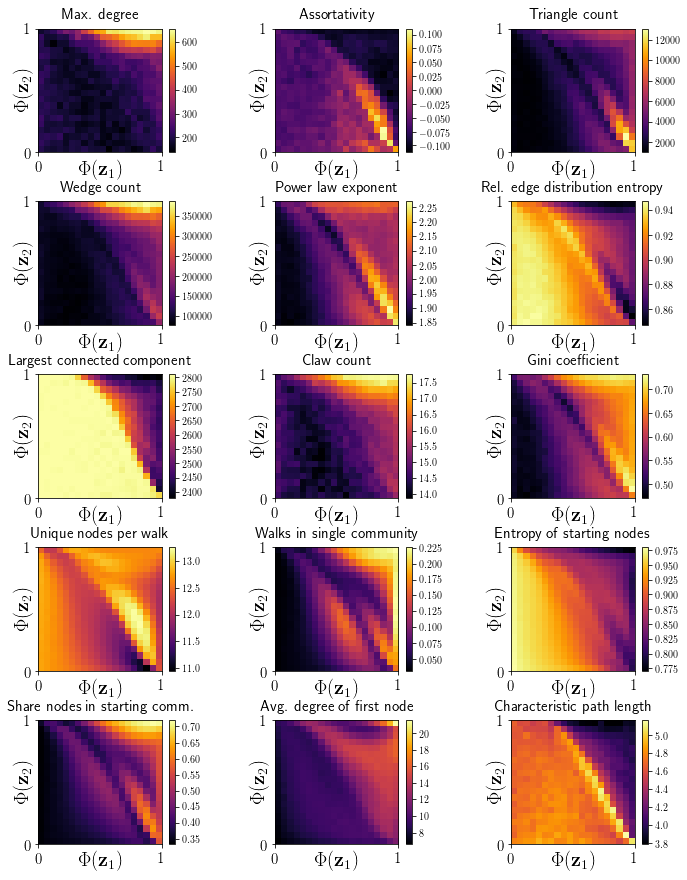

In [67]:
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10 

n_cols = 3
n_rows = int(np.ceil(len(display_titles)/n_cols))
fig=plt.figure(figsize=(4*n_cols,3*n_rows))

gs = gridspec.GridSpec(n_rows, n_cols, hspace=0.4)

for ix,key in enumerate(eval_keys):
    ax = plt.subplot(gs[ix // n_cols, ix % n_cols])
    vals = statistics_dict[key]
    heatmap(vals, ax, cbar=True, title=display_titles[key])

plt.savefig("intermediate/heatmaps.png", dpi=150)
plt.show()

## Community structure plots

In [ ]:
n_bins_community = 10
bins_community = np.arange(0, 1, 1/n_bins_community)

In [ ]:
noise_bins_community = np.floor(all_noise /  (1/n_bins_community)).astype('int')

In [ ]:
graphs = [[None for i in range(n_bins_community)] for j in range(n_bins_community)]
begin = time.time()
it = 0

for x1 in range(n_bins_community):
    for x2 in range(n_bins_community):
        it += 1
        scores = utils.score_matrix_from_random_walks(all_walks[np.where((noise_bins[:,0] == x1) &
                                                                       (noise_bins[:,1] == x2))], netgan.N)
        graph_select = utils.graph_from_scores(scores, A_select.sum())
        graphs[x1][x2] = sp.coo_matrix(graph_select)
        elapsed = time.time() - begin
    print("{}/{} took {:.2f}, eta {:.2f}".format(it, n_bins_community**2, elapsed, (n_bins_community**2)/(it)*elapsed - elapsed))

In [ ]:
all_scores = utils.score_matrix_from_random_walks(all_walks, netgan.N)
all_graph_select = utils.graph_from_scores(sp.coo_matrix(all_scores), A_select.sum())

In [ ]:
np.savez_compressed('intermediate/results_communities_{}x{}.npz'.format(n_bins_community, n_bins_community), 
                    graphs = graphs,
                    all_walks_graph = sp.csr_matrix(all_graph_select))

## Load statistics from file (start here if you just want to run the visualization)

### Uncomment the following to load from disk

In [ ]:
#n_bins_community = 10
#results = np.load('intermediate/results_communities_{}x{}.npz'.format(noise_bins_community, noise_bins_community))
#graphs = results['graphs']
#all_graph_select = results['all_walks_graph'].item()

In [ ]:
from collections import Counter

In [ ]:
n_communities = _z_obs.max()+1

In [ ]:
distrs = []
for x in range(len(graphs)):
    for y in range(len(graphs[x])):
        graph_internal = graphs[x][y]
        edges = np.transpose(graph_internal.nonzero())
        edges_communities = _z_obs[edges]
        blocks = np.zeros((n_communities, n_communities))
        blocks[edges_communities[:,0], edges_communities[:,1]] 
        tpls = list(map(tuple, edges_communities))
        counts = Counter(tpls)
        for k,v in counts.items():
            blocks[k] = v
        distrs.append(blocks)

In [ ]:
distrs = np.array(distrs).reshape([n_bins_community, n_bins_community,n_communities, n_communities])

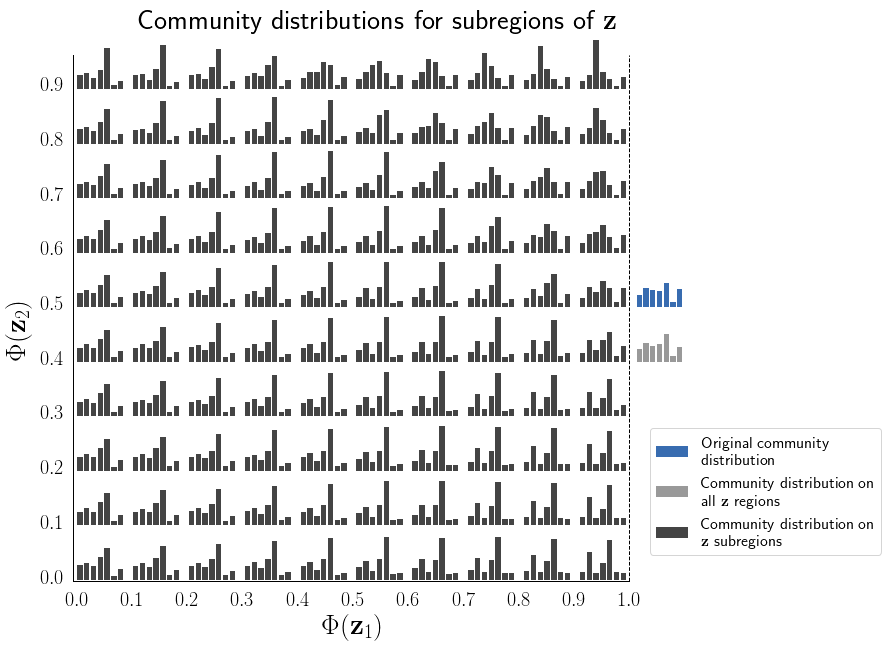

In [65]:
import matplotlib.patches as patches
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 


font = {'family': 'serif',
        'weight': 'normal',
        'size': 28,
        'ha': 'center',
        'va': 'center'
        }

fig = plt.figure(figsize=(11, 10))
max_height = np.max(np.sum(distrs, axis=2))

# gridspec inside gridspec
outer_grid = gridspec.GridSpec(1, 2, wspace=0.02, hspace=0.0, width_ratios=[11, 1], bottom=0.13, left=0.13)

inner_grid_1 = gridspec.GridSpecFromSubplotSpec(n_bins_community, n_bins_community,
            subplot_spec=outer_grid[0], wspace=0.1, hspace=.1)

for x_ix in range(distrs.shape[0]):
    for y_ix in range(distrs.shape[1]):
        ax = plt.Subplot(fig, inner_grid_1[x_ix, y_ix])
        distr = distrs[x_ix][y_ix]
        plot_normal = ax.bar(np.arange(n_communities), np.sum(distr, axis=0), color='#444444')

        ax.set_xticks([])
        ax.set_yticks([])

        fig.add_subplot(ax)
        plt.ylim((0, max_height))
        plt.axis('off')


inner_grid_2 = gridspec.GridSpecFromSubplotSpec(n_bins_community, 1,
            subplot_spec=outer_grid[1], wspace=0.0, hspace=0.1)

# original graph
ax = plt.Subplot(fig, inner_grid_2[int(n_bins_community/2)-1, 0])
ax.patch.set_alpha(0.0)
distr = np.zeros([n_communities, n_communities])
graph_int = A_select
for i in range(n_communities):
    for j in range(n_communities):
        sel = A_select[_z_obs ==i]
        sel = sel[:,_z_obs == j]
        distr[i,j] = sel.sum()
plot_orig = ax.bar(np.arange(n_communities), np.sum(distr, axis=0),color='#386cb0')
fig.add_subplot(ax)
plt.ylim((0, max_height))
plt.axis('off')

# graph from all regions of z
ax = plt.Subplot(fig, inner_grid_2[int(n_bins_community/2), 0])
ax.patch.set_alpha(0.0)
distr = np.zeros([n_communities, n_communities])
graph_int = all_graph_select
for i in range(n_communities):
    for j in range(n_communities):
        sel = all_graph_select[_z_obs ==i]
        sel = sel[:,_z_obs == j]
        distr[i,j] = sel.sum()
plot_all_sample = ax.bar(np.arange(n_communities), np.sum(distr, axis=0),color='#999999')
fig.add_subplot(ax)
plt.ylim((0, max_height))
plt.axis('off')


all_axes = fig.get_axes()
    
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)

ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,1.1,0.1))
plt.tick_params(axis='both', which='major', labelsize=20)
text_left = plt.text(-0.1, 0.45, r'$\Phi(\mathbf{z}_2)$', fontdict=font, rotation=90)
text_bot = plt.text(0.5, -0.1, r'$\Phi(\mathbf{z}_1)$', fontdict=font, rotation=0)
plt.xlim((-.01, 1 + 1/n_bins_community))
plt.ylim((-.015, .9785))
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
plt.title("Community distributions for subregions of $\mathbf{z}$", fontdict=font)
lgd = plt.legend([plot_orig, plot_all_sample, plot_normal],
           ["Original community\ndistribution",
            "Community distribution on\nall $\mathbf{z}$ regions",
            "Community distribution on\n$\mathbf{z}$ subregions"],
           bbox_to_anchor=(0.93, 0.3), labelspacing=.5, fontsize=16)
ax.plot([-0.006,-.006],[-.011,.95] , 'k-', lw=1)
ax.plot([.999,.999],[-.011,.95] , 'k--', lw=1)
ax.plot([-0.006,.999],[-.011,-.011] , 'k-', lw=1)

#plt.savefig( "{}_community_distr_{}x{}.pdf".format('cora', n_bins_community, n_bins_community),
#           bbox_extra_artists=( text_left, text_bot), bbox_inches='tight')
plt.show()